Final Project Submission

Student name: Mark Ehler <br>
Student pace: part time <br>
Scheduled project review date/time: 07 28  2019 MDT US <br>
Instructor name: Jeff Herman <br>
Blog post URL: https://docs.google.com/document/d/1at-jaYU3fUA27ddn36ti3UFJEaUGrKlr0OrJ9GUVmnQ/edit?usp=sharing

<h4> RNN For Sentiment Analysis </h4>

Intro for final model...

This module uses the <a href=" https://www.kaggle.com/zynicide/wine-reviewsdata ">Wine Reviews </a> dataset availible on Kaggle to determine sentiment analysis of the wine after reading only a short review.  The goal being to deveolop an RNN that can organize text data. Results will be ran against a straight-forward logistic regression model test the strength of the sentiment analysis model.


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Input, Embedding, Flatten, Dense, Dropout, Activation, Bidirectional, LSTM, GlobalMaxPool1D #different layers we might use
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical, Sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import  sequence
from keras.callbacks import History 

In [2]:
%store -r 

reviews = pd.read_csv('_review_data.csv') # all cleaned data
stop_removed_text = stop_removed_text # preprocessed but unsorted # currently pointing to this iteration
trainDataVecs = trainDataVecs # presorted processed tokens
testDataVecs = testDataVecs # presorted processed tokens
print(reviews.columns)


Index(['Unnamed: 0', 'description', 'two_outcomes'], dtype='object')


In [3]:

total_vocabulary = set(word for line in stop_removed_text for word in line)

len(total_vocabulary)

30241

In [4]:
glove_dir = r'C:\Users\Mark\Documents\DataSci\glove_dir\glove.6B.50d.txt' #r prefix converts from a normal string to a raw string
glove = {}
with open(glove_dir, 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector
print(f'Found {len(glove)} word vectors.')

Found 24127 word vectors.


<h3> Tokenize the Text </h3>

In [5]:
# Adapted from Deep learning RNN Chapter
maxlen = 40 # no reviews are longer than 40 words
max_words = 10000 # do I use this # for the embedding layer my data.shape[0] which is 129907 for the entire set 
def keras_enc(samples, maxlen=maxlen):
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(samples)

    sample_sequences = tokenizer.texts_to_sequences(samples)

    word_index = tokenizer.word_index
    print(f'found {len(word_index)} unique tokens')
    
    samples_transformed = sequence.pad_sequences(sample_sequences, maxlen=maxlen)
    
    return samples_transformed, word_index

In [6]:
desc_t, word_index = keras_enc(stop_removed_text)

found 30241 unique tokens


<h3> Create Embedding Matrix with Pretrained Network </h3>

In [7]:
glove_dir = r'C:\Users\Mark\Documents\DataSci\glove_dir\glove.6B.50d.txt' #r prefix converts from a normal string to a raw string
embedding_index = {}
with open(glove_dir, 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in word_index.keys():
            vector = np.array(parts[1:], dtype=np.float32)
            embedding_index[word] = vector
print(f'Found {len(embedding_index)} word vectors.')
print(f'{round(( len(embedding_index)/len(total_vocabulary) *100),2)}% word coverage')

Found 24127 word vectors.
79.78% word coverage


In [8]:
embedding_dim = 50 # This GloVe seems to use vector arrays in the shape (50,)
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [9]:
embedding_matrix[1]

array([-0.1145    ,  0.75404   , -1.64320004, -0.61037999,  0.60351998,
       -0.56396002, -1.00689995, -0.44103   ,  0.61255997,  1.18120003,
        0.18128   ,  0.30032   ,  1.18169999, -0.62548   ,  1.21560001,
       -0.30737999,  0.54095   ,  0.53758001, -0.026086  , -1.73870003,
        0.46533   , -0.62835002,  0.50936002,  1.11919999, -0.74747002,
       -0.57528001, -0.92030001,  0.98611999,  0.29107001,  0.60207999,
        1.97029996, -0.27461001, -0.34920999,  0.44141001,  0.64402002,
       -0.32352999, -1.45410001,  1.14719999,  0.86874998, -0.074512  ,
        0.85632002,  0.59341002,  0.4655    , -0.0387    ,  0.26462999,
        0.94151002, -0.27335   , -0.085403  ,  0.12693   , -0.23861   ])

In [12]:
# create a test split

X_nn_train = desc_t[:99999]
X_nn_test = desc_t[99999:]
labels_train = reviews['two_outcomes'][:99999]
labels_test = reviews['two_outcomes'][99999:]

input_shape = X_nn_train.shape
input_shape

(99999, 40)

In [13]:
# shape of labels. this variable will be used to fit model
labels_shape = labels_train.shape
labels_shape

(99999,)

In [17]:
# data was used in this vector to build a random forest model previously
trainDataVecs.shape

(90935, 50)

In [78]:
checkpoints_path = 'wine_reviews.best.hdf5'
checkpoint = ModelCheckpoint(checkpoints_path, monitor='val_loss', 
                             verbose=0, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='loss', mode='min', patience=10)
history = History()
callbacks = [checkpoint, early_stopping, history]

<h3> Test Neural Network on Data </h3>

In [ ]:
#  new model architecture


# new_model.compile(loss='binary_crossentropy',
#                  )

In [15]:
test_model = Sequential()
test_model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen,
                         weights=[embedding_matrix], trainable=False ))
test_model.add(Flatten())
test_model.add(Dense(32, activation='relu'))
test_model.add(Dense(1, activation='sigmoid'))
test_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 50)            500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                64032     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 564,065
Trainable params: 64,065
Non-trainable params: 500,000
_________________________________________________________________


In [18]:
%%time
# X_nn_train, labels_train
test_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['acc'])
history = test_model.fit(X_nn_train, labels_train, epochs=50, batch_size=128,
                    validation_split=0.1, callbacks=callbacks)

Train on 89999 samples, validate on 10000 samples
Epoch 1/50
89999/89999 [==============================] - 3s 37us/step - loss: 0.1385 - acc: 0.9475 - val_loss: 0.9457 - val_acc: 0.7558

Epoch 00001: val_loss improved from inf to 0.94574, saving model to wine_reviews.best.hdf5
Epoch 2/50
89999/89999 [==============================] - 3s 29us/step - loss: 0.1215 - acc: 0.9559 - val_loss: 0.9703 - val_acc: 0.7594

Epoch 00002: val_loss did not improve from 0.94574
Epoch 3/50
89999/89999 [==============================] - 3s 28us/step - loss: 0.1166 - acc: 0.9571 - val_loss: 1.0150 - val_acc: 0.7619

Epoch 00003: val_loss did not improve from 0.94574
Epoch 4/50
89999/89999 [==============================] - 3s 29us/step - loss: 0.1043 - acc: 0.9628 - val_loss: 1.0539 - val_acc: 0.7620

Epoch 00004: val_loss did not improve from 0.94574
Epoch 5/50
89999/89999 [==============================] - 3s 29us/step - loss: 0.0989 - acc: 0.9648 - val_loss: 1.1024 - val_acc: 0.7606

Epoch 00005: val

In [2]:
def plot_results(hist):
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    
    epochs = range(1,len(acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('% accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='best')
    
    plt.show();
    
    plt.plot(epochs, loss, 'bo', label='Training Loss', color='orange')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show();

We pretty quickly overfit here, but the results are nothing to s

In [23]:
model_two = Sequential()
model_two.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen,
                         weights=[embedding_matrix], trainable=False ))
model_two.add(Flatten())
model_two.add(Dropout(0.5))
model_two.add(Dense(32, activation='relu'))
model_two.add(Dense(1, activation='sigmoid'))
model_two.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 40, 50)            500000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                64032     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 564,065
Trainable params: 64,065
Non-trainable params: 500,000
_________________________________________________________________


In [47]:
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def k_folds(features_train, labels_train, model_obj, k=10, n_epochs=50):
    colors = sns.color_palette("Set2")

    validation_scores = [] 
    
    kf = KFold(n_splits=10, shuffle=True)
    
    fig, axes = plt.subplots(2, 5, figsize=(12,8))
    for i, (train_index, test_index) in enumerate(kf.split(features_train)):
        "Currently graph imaging assumes 10 folds and is hardcoded to 5x2 layout."
        row = i//5
        col = i%5
        X_train, X_val = features_train[train_index], features_train[test_index]
        y_train, y_val = labels_train[train_index], labels_train[test_index]
        
        model = model_obj
        hist = model.fit(X_train, y_train, batch_size=32,
                         epochs=n_epochs, verbose=0,
                         validation_data = (X_val, y_val),
                         callbacks=callbacks)
        #Note: verboxe=0 turns off printouts regarding training for each epoch.
        print("| (• ◡•)| (❍ᴥ❍ʋ)   #" + str(i))
        validation_score = model.evaluate(X_val, y_val)
        validation_scores.append(validation_score)
        ax = axes[row, col]
        k = 'val_loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[0])

        k = 'loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[1])
        ax.set_title('Fold {} Validation'.format(i+1))
    #Final Graph Formatting
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.legend(bbox_to_anchor=(1,1))
    
    #General Overview
    validation_score = np.average(validation_scores)
    print('Mean Validation Score:', validation_score)
    print('Standard Deviation of Validation Scores:', np.std(validation_scores))
    return validation_score

In [26]:
model_two.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['acc'])

9999/9999 [==============================] - 0s 25us/step
Mean Validation Score: 0.6124043023283462
Standard Deviation of Validation Scores: 0.18748476500410804
Wall time: 2h 4min 54s


0.6124043023283462

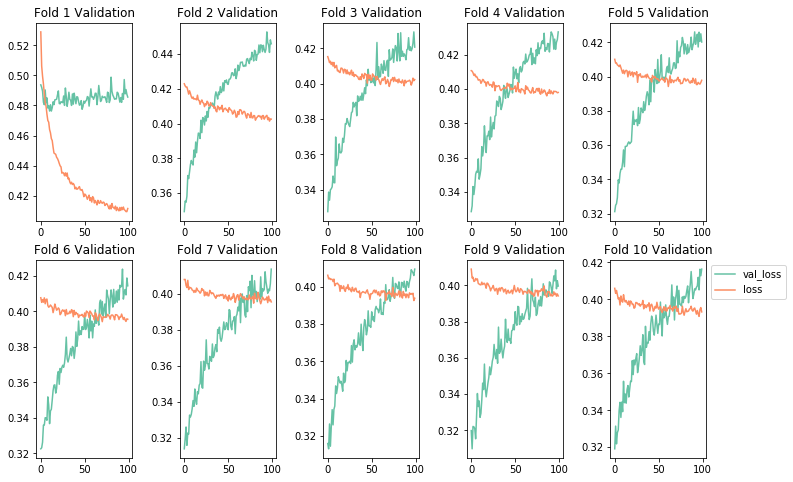

In [39]:
%%time
k_folds(X_nn_train, labels_train, model_two)
# history = model_two.fit(X_nn_train, labels_train, epochs=50, batch_size=128,
#                     validation_split=0.1, callbacks=callbacks)

In [43]:
print(model_two.metrics_names)

['loss', 'acc']


In [72]:
test_results = model_two.evaluate(X_nn_test, labels_test)
print(f'Test set loss:{test_results[0]}\nTest set accuracy:{test_results[1]}')

29908/29908 [==============================] - 1s 38us/step
Test set loss:0.48568778122844136
Test set accuracy:0.7676207034827331


One dropout layer acutally improved the model significantly.  Curious, that forgetting information made results immediately on the first epoch.  To me, this shows a serious overfitting problem.

In [46]:
model_three = Sequential()
model_three.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen,
                         weights=[embedding_matrix], trainable=False ))
model_three.add(Flatten())
model_three.add(Dropout(0.75))
model_three.add(Dense(32, activation='relu'))
model_three.add(Dropout(0.5))
model_three.add(Dense(1, activation='sigmoid'))
model_three.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 50)            500000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                64032     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 564,065
Trainable params: 64,065
Non-trainable params: 500,000
_________________________________________________________________

In [48]:
model_three.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['acc'])
# history = model_three.fit(X_nn_train, labels_train, epochs=50, batch_size=64,
#                     validation_split=0.1, callbacks=callbacks)


Epoch 00001: val_loss improved from 0.94574 to 0.31920, saving model to wine_reviews.best.hdf5

Epoch 00002: val_loss did not improve from 0.31920

Epoch 00003: val_loss improved from 0.31920 to 0.31895, saving model to wine_reviews.best.hdf5

Epoch 00004: val_loss did not improve from 0.31895

Epoch 00005: val_loss did not improve from 0.31895

Epoch 00006: val_loss did not improve from 0.31895

Epoch 00007: val_loss did not improve from 0.31895

Epoch 00008: val_loss did not improve from 0.31895

Epoch 00009: val_loss did not improve from 0.31895

Epoch 00010: val_loss did not improve from 0.31895

Epoch 00011: val_loss did not improve from 0.31895

Epoch 00012: val_loss did not improve from 0.31895

Epoch 00013: val_loss did not improve from 0.31895

Epoch 00014: val_loss did not improve from 0.31895

Epoch 00015: val_loss did not improve from 0.31895

Epoch 00016: val_loss did not improve from 0.31895

Epoch 00017: val_loss did not improve from 0.31895

Epoch 00018: val_loss did n

0.6016447785227388

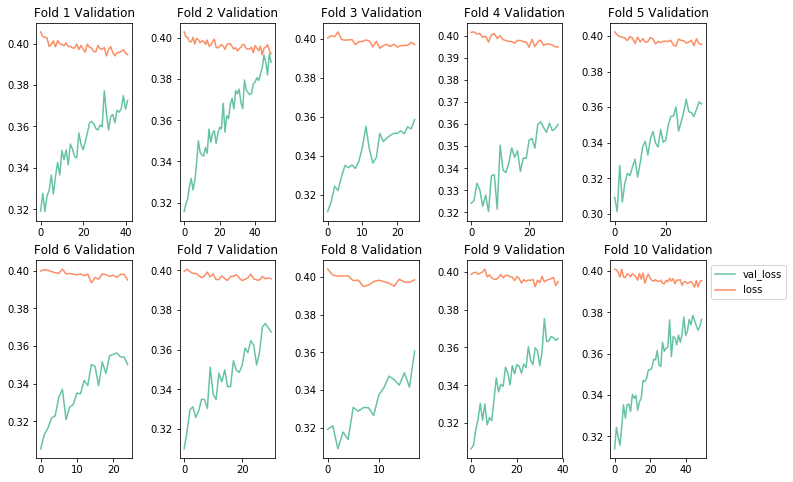

In [49]:
%%time
k_folds(X_nn_train, labels_train, model_two)

In [51]:
test_results = model_three.evaluate(X_nn_test, labels_test)
print(f'Test set loss:{test_results[0]}\nTest set accuracy:{test_results[1]}')

29908/29908 [==============================] - 1s 31us/step
Test set loss:0.8005219591370205
Test set accuracy:0.4156078641166243


In [69]:
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import itertools 

In [52]:


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [58]:
# def plot_conf_matrix(cm, classes, normalize=False, 
#                           title='Confusion Matrix', cmap=plt.cm.Blues):
#     '''
#     Draws a heat map to show true positives, false positives, &c
#     for given predicted y values vs actual y values.
#     Parameters:
#     cm (np.array) The confusion matrix for a model's predictions.
#     classes (list) Names of classes/categories.
#     normalize (bool) Whether to normalize the numbers in the matrix.
#     Returns:
#     Visualized heat map of the confusion matrix.
#     '''
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [99]:
# y_hat_train = model_two.predict(X_nn_train)
# y_hat_test = model_two.predict(X_nn_test)

# classes = [0, 1]

# cm = confusion_matrix(labels_train, y_hat_train.argmax(axis = 1))
# plot_conf_matrix(cm, classes )
# plt.savefig('Confusion Matrix')
# plt.show();

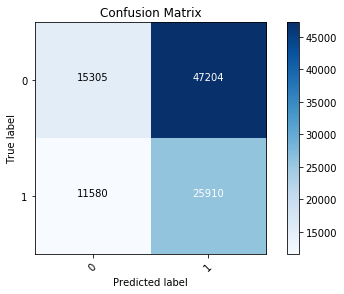

In [95]:
#Look at confusion matrix of results
y_hat_train = model_three.predict(X_nn_train)
y_hat_test = model_three.predict(X_nn_test)

classes = [0, 1]

cm = confusion_matrix(labels_train, np.round_(y_hat_train, decimals=0))
plot_conf_matrix(cm, classes )
plt.savefig('Confusion Matrix')
plt.show();

In [73]:
model_four = Sequential()
model_four.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen,
                         weights=[embedding_matrix], trainable=False ))
model_four.add(LSTM(50, return_sequences=True))
model_four.add(GlobalMaxPool1D())
model_four.add(Dropout(0.5))
model_four.add(Dense(32, kernel_regularizer=regularizers.l2(0.005), activation='relu'))))
model_four.add(Dropout(0.50))
model_four.add(Dense(1, activation='sigmoid'))
model_four.summary()


# model_three.add(Flatten())
# model_three.add(Dropout(0.5))
# lstm_model.add(Dense(50, activation='relu'))
# lstm_model.add(Dropout(0.25))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 50)            500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 50)            20200     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1632      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total para

In [12]:
# lstm_model.layers[0].set_weights([embedding_matrix])
# model.layers[0].trainable = False

In [93]:
%%time
model_four.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['acc'])
history = model_four.fit(X_nn_train, labels_train, epochs=40, batch_size=128,
                    validation_split=0.1, callbacks=callbacks)

Train on 89999 samples, validate on 10000 samples
Epoch 1/40
89999/89999 [==============================] - 28s 306us/step - loss: 0.2619 - acc: 0.8948 - val_loss: 0.2295 - val_acc: 0.9100
Epoch 2/40
89999/89999 [==============================] - 26s 285us/step - loss: 0.2536 - acc: 0.8991 - val_loss: 0.2308 - val_acc: 0.9071
Epoch 3/40
89999/89999 [==============================] - 27s 296us/step - loss: 0.2475 - acc: 0.9010 - val_loss: 0.2367 - val_acc: 0.9051
Epoch 4/40
89999/89999 [==============================] - 26s 284us/step - loss: 0.2445 - acc: 0.9010 - val_loss: 0.2414 - val_acc: 0.9003
Epoch 5/40
89999/89999 [==============================] - 25s 279us/step - loss: 0.2830 - acc: 0.8873 - val_loss: 0.2521 - val_acc: 0.8963
Epoch 6/40
89999/89999 [==============================] - 25s 281us/step - loss: 0.2549 - acc: 0.8986 - val_loss: 0.2411 - val_acc: 0.9000
Epoch 7/40
89999/89999 [==============================] - 29s 317us/step - loss: 0.2426 - acc: 0.9040 - val_loss: 0.

In [ ]:
# % accuracy not MAE

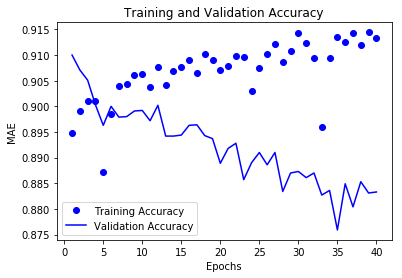

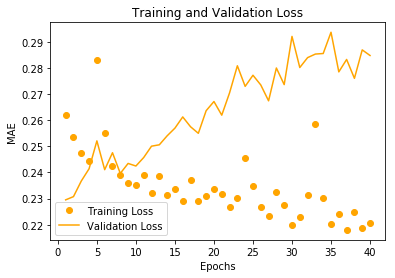

In [94]:
plot_results(history)

In [100]:
train_results = model_four.evaluate(X_nn_train, labels_train)
print(f'Train set loss:{train_results[0]}\nTrain set accuracy:{train_results[1]}')
test_results = model_four.evaluate(X_nn_test, labels_test)
print(f'Test set loss:{test_results[0]}\nTest set accuracy:{test_results[1]}')

99999/99999 [==============================] - 36s 362us/step
Train set loss:0.20839801707948535
Train set accuracy:0.9261992619860634
29908/29908 [==============================] - 10s 344us/step
Test set loss:0.49788718994458253
Test set accuracy:0.8132272301685433


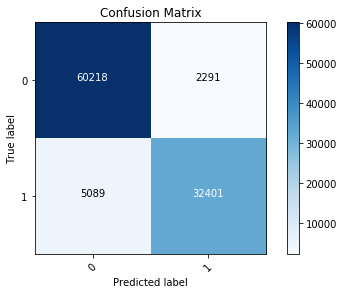

In [97]:
#Look at confusion matrix of results
y_hat_train = model_four.predict(X_nn_train)
y_hat_test = model_four.predict(X_nn_test)

classes = [0, 1]

cm = confusion_matrix(labels_train, np.round_(y_hat_train, decimals=0))
plot_conf_matrix(cm, classes )
plt.savefig('Confusion Matrix')
plt.show();

<h3> Conclusion </h3>

The final model complete with L2 regularization and an LSTM RNN layer prefromed markedly better than the random forest model from the associated module.  We can confirm that there is at least some improvement.

<h4> Further Findings </h4>

Create data by giving each wine a new name based on their taster description.

Build a live  recommender system that pairs likely flavors and suggests wines that fit the search criteria.

